In [21]:
from audioop import avg
import cmath
from fileinput import filename
from gc import enable
import sys
from matplotlib.pyplot import axis
import pandas as pd
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, roc_auc_score, auc 
import warnings
import pickle
import tensorflow as tf
from fastprogress import fastprogress
warnings.filterwarnings("ignore")
from fastai.tabular.all import *
import os

dataPath = ('../dataset/UGR/')
modelPath = '../UGR/'
df_train = pd.read_csv('../dataset/UGR/train.csv')
df_test = pd.read_csv('../dataset/UGR/test.csv')

print(df_train['Label'].value_counts())

labels = ['background', 'scan11', 'scan44', 'blacklist', 'nerisbotnet', 'dos', 'anomaly-spam', 'anomaly-sshscan']
y_names = 'Label'

cat_names = ['source_ip', 'dest_ip', 'flag2', 'flag3', 
             'flag4', 'flag5', 'flag6', 'source_port', 
             'dest_port', 'protocol']

cont_names = ['hour', 'minute', 'second', 'duration', 
             'stos', 'pkt', 'byt']

procs = [Categorify, FillMissing, Normalize]

verbose = 1
params = {'n_estimators': 400,
    #'tree_method':'exact',
    'learning_rate': 0.3,
    'objective': 'multi:softmax',
    'booster': 'gbtree',
    'max_depth': 10,
    'n_jobs': 4, 
    'num_class': 8,  
    #'use_label_encoder': False,
    'eval_metric':"mlogloss" 
}
print('XGBoost Training model...')
model = xgb.XGBClassifier(**params)
xgb_model = model.fit(df_train[df_train.columns[:-1]], df_train[y_names])
print('XGBoost Predicting...')
start = time.time()
xgb_preds = xgb_model.predict_proba(df_test[df_test.columns[:-1]])
elapsed_xgb = time.time() - start
print('XGBoost Finish...')

print('DNN Training model...')
acc1 = 0.8
acc3 = 0.1
step = 0
while acc3 < 0.5555:
    step = step + 1
    print('Training model...', step )
    print('Setting model...' )
        # create model labels=labels,
    dls = TabularDataLoaders.from_df(df_train, path=dataPath, procs=procs, y_names=y_names, bs=350) #, valid_idx=list(range(1,test.shape[0])))
    roc_auc = RocAuc(average='weighted')
    learn = tabular_learner(dls, layers=[200,100], metrics=[accuracy, Precision(average='weighted'), F1Score(average='weighted'), Recall(average='weighted'), roc_auc])
    learn.fit(2, 1e-2)
    dl = learn.dls.test_dl(df_test, with_labels=True, drop_last=False)
    
    print("DNN Predicting...")
    start = time.time()
    nn_preds, tests, clas_idx = learn.get_preds(dl=dl, with_loss=False, with_decoded=True)
    elapsed = time.time() - start
    
    print('Printing result of DNN')
    loss, acc, precision, f1, recall, roc = learn.validate(dl=dl)
    print('Accuracy: {:.2f}%; precision: {:.2f}%; F1: {:.2f}%; Recall: {:.2f}%; roc-auc: {:.2f}%; elapsed: {:.2f} s'.format(acc*100, precision*100, f1*100, recall*100, roc*100,  elapsed ))
    
    acc1 = accuracy(tensor(xgb_preds), tensor(tests))
    print('Accuracy of XGBoost: {:.2f}%' .format(acc1*100,))
    
    acc2 = accuracy(tensor(nn_preds), tensor(tests))
    print('Accuracy of DNN: {:.2f}%' .format(acc2*100,))
    
    start = time.time()
    avgs = (nn_preds + xgb_preds) / 2
    elapsed_ensemble = time.time() - start
    
    argmax = avgs.argmax(dim=1)    
    acc3 = accuracy(tensor(avgs), tensor(tests))
    #print('Accuracy of Ensemble: {:.2f}%' .format(acc3*100,))

print("-----FINAL------")
print("XGBboost_Elapsed: ", elapsed_xgb)
print('DNN_Elapsed: ', elapsed)
print("------>")
print('Printing XGBoost result')
precision1 = precision_score(tests, xgb_preds.argmax(axis=1), average='weighted')
f11 = f1_score(tests, xgb_preds.argmax(axis=1), average='weighted')
recall1 = recall_score(tests, xgb_preds.argmax(axis=1), average='weighted')
print('Accuracy: {:.2f}%; precision: {:.2f}%; F1: {:.2f}%; Recall: {:.2f}%; elapsed: {:.2f} s'.format(acc1*100, precision1*100, f11*100, recall1*100,  elapsed_xgb ))
print(classification_report(xgb_preds.argmax(axis=1),tests))
cm = confusion_matrix(tests,np.argmax(xgb_preds, axis=1))
print(cm)
print("------>")
print('Printing result of Ensemble learning')
accuracy3 = accuracy_score(tests, avgs.argmax(axis=1))
precision3 = precision_score(tests, avgs.argmax(axis=1), average='weighted')
f13 = f1_score(tests, avgs.argmax(axis=1), average='weighted')
recall3 = recall_score(tests, avgs.argmax(axis=1), average='weighted')
print('Accuracy: {:.2f}%; precision: {:.2f}%; F1: {:.2f}%; Recall: {:.2f}%; elapsed: {:.2f} s'.format(accuracy3*100, precision3*100, f13*100, recall3*100,  elapsed_ensemble ))
print("Elapsed_Ensemble: ", elapsed_ensemble)
print(classification_report(avgs.argmax(axis=1), tests))
cm = confusion_matrix(tests,avgs.argmax(axis=1))
print(cm)

scan44             14093
anomaly-spam       14029
anomaly-sshscan    14029
nerisbotnet        14029
background         14029
dos                14029
scan11             14016
blacklist          14013
Name: Label, dtype: int64
XGBoost Training model...
XGBoost Predicting...
XGBoost Finish...
DNN Training model...
Training model... 1
Setting model...


epoch,train_loss,valid_loss,accuracy,precision_score,f1_score,recall_score,roc_auc_score,time
0,0.246597,0.310999,0.884247,0.892758,0.886582,0.884247,0.985262,00:09
1,0.219962,0.262301,0.896450,0.908221,0.896620,0.896450,0.988345,00:04


DNN Predicting...


Printing result of DNN


Accuracy: 80.94%; precision: 83.35%; F1: 80.99%; Recall: 80.94%; roc-auc: 95.58%; elapsed: 1.22 s
Accuracy of XGBoost: 99.34%
Accuracy of DNN: 80.94%
-----FINAL------
XGBboost_Elapsed:  0.7022082805633545
DNN_Elapsed:  1.2203688621520996
------>
Printing XGBoost result
Accuracy: 99.34%; precision: 99.35%; F1: 99.34%; Recall: 99.34%; elapsed: 0.70 s
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       129
           1       0.97      1.00      0.99        33
           2       1.00      0.98      0.99      6085
           3       0.98      1.00      0.99      5885
           4       1.00      1.00      1.00      1336
           5       0.99      1.00      0.99       564
           6       1.00      1.00      1.00      5983
           7       1.00      1.00      1.00      5907

    accuracy                           0.99     25922
   macro avg       0.99      1.00      0.99     25922
weighted avg       0.99      0.99      0.99     25922

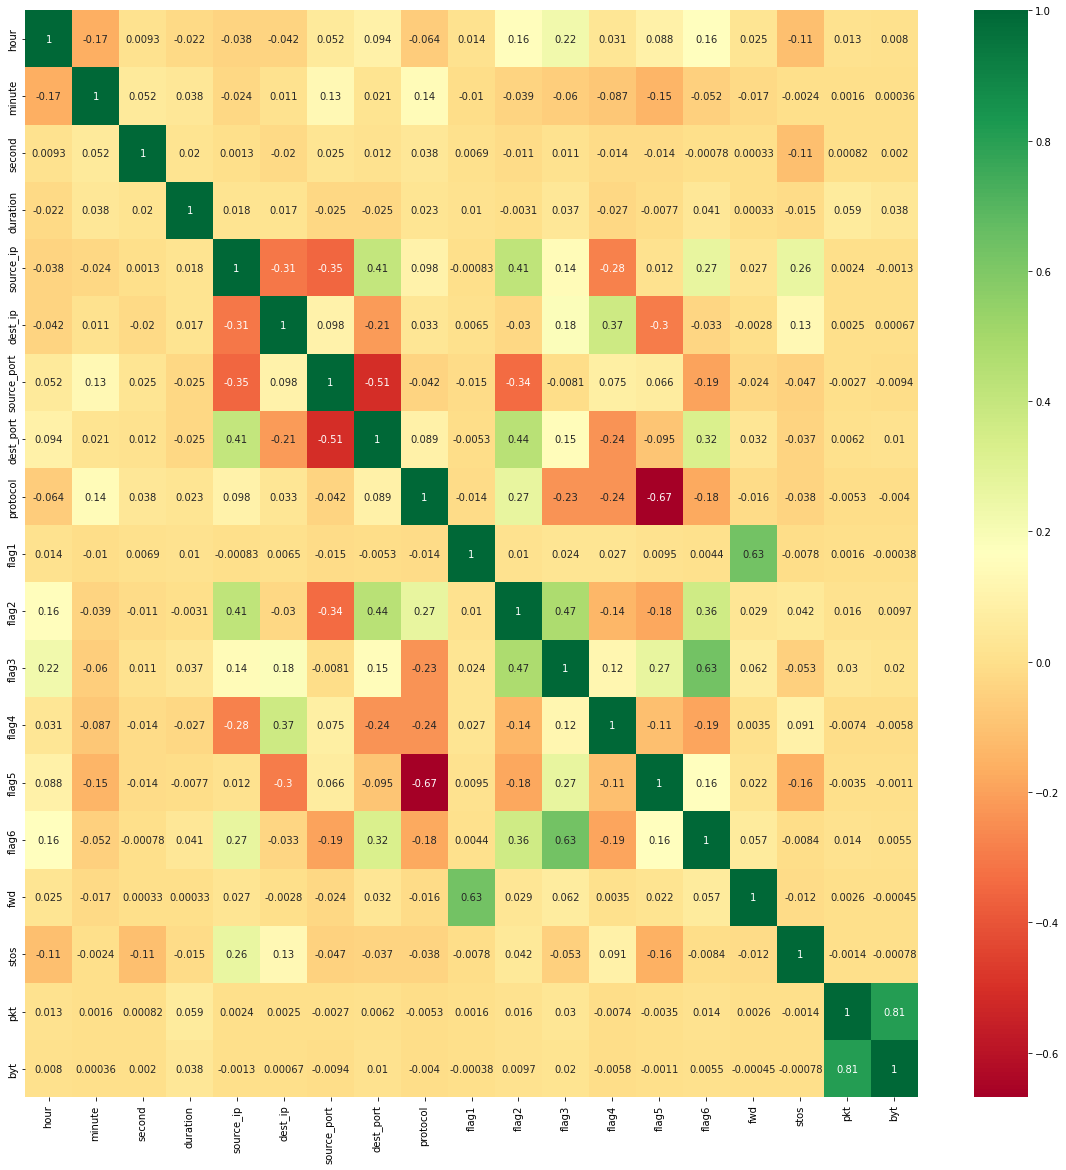

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_train = pd.read_csv('../dataset/UGR/train.csv')

corrmat = df_train.corr()
top = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(df_train[top].corr(),annot=True,cmap="RdYlGn")


In [ ]:
cat_col = list(df_train.select_dtypes(include=object).columns.values)
cat_col

In [25]:
from audioop import avg
import cmath
from fileinput import filename
from gc import enable
import sys
from matplotlib.pyplot import axis
import pandas as pd
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, roc_auc_score, auc 
import warnings
import pickle
import tensorflow as tf
from fastprogress import fastprogress
warnings.filterwarnings("ignore")
from fastai.tabular.all import *
import os

dataPath = ('../dataset/UGR/')
modelPath = '../UGR/'
df_train = pd.read_csv('../dataset/UGR/train_ori.csv')
df_test = pd.read_csv('../dataset/UGR/test.csv')

print(df_train['Label'].value_counts())

labels = ['background', 'scan11', 'scan44', 'blacklist', 'nerisbotnet', 'dos', 'anomaly-spam', 'anomaly-sshscan']

cat_names = ['hour', 'minute', 'second', 'duration', 'source_ip', 'dest_ip', 'protocol', 
             'flag2', 'flag3', 'flag4', 'flag5', 'flag6',
            'source_port', 'dest_port']
y_names = 'Label'

cont_names = ['stos', 'pkt', 'byt']

procs = [Categorify, FillMissing, Normalize]

verbose = 1
params = {'n_estimators': 400,
    #'tree_method':'exact',
    'learning_rate': 0.3,
    'objective': 'multi:softmax',
    'booster': 'gbtree',
    'max_depth': 10,
    'n_jobs': 4, 
    'num_class': 8,  
    #'use_label_encoder': False,
    'eval_metric':"mlogloss" 
}
print('XGBoost Training model...')
model = xgb.XGBClassifier(**params)
xgb_model = model.fit(df_train[df_train.columns[:-1]], df_train[y_names])
print('XGBoost Predicting...')
start = time.time()
xgb_preds = xgb_model.predict_proba(df_test[df_test.columns[:-1]])
elapsed_xgb = time.time() - start
print('XGBoost Finish...')

print('DNN Training model...')
acc1 = 0.8
acc3 = 0.1
step = 0
while acc3 < 0.5555:
    step = step + 1
    print('Training model...', step )
    print('Setting model...' )
        # create model
    dls = TabularDataLoaders.from_df(df_train, path=dataPath, procs=procs, y_names=y_names, bs=64) #, valid_idx=list(range(1,test.shape[0])))
    roc_auc = RocAuc(average='weighted')
    learn = tabular_learner(dls, layers=[400,200], metrics=[accuracy, Precision(average='weighted'), F1Score(average='weighted'), Recall(average='weighted'), roc_auc])
    learn.fit(2, 1e-2)
    dl = learn.dls.test_dl(df_test, with_labels=True, drop_last=False)
    
    print("DNN Predicting...")
    start = time.time()
    nn_preds, tests, clas_idx = learn.get_preds(dl=dl, with_loss=False, with_decoded=True)
    elapsed = time.time() - start
    
    print('Printing result of DNN')
    loss, acc, precision, f1, recall, roc = learn.validate(dl=dl)
    print('Accuracy: {:.2f}%; precision: {:.2f}%; F1: {:.2f}%; Recall: {:.2f}%; roc-auc: {:.2f}%; elapsed: {:.2f} s'.format(acc*100, precision*100, f1*100, recall*100, roc*100,  elapsed ))
    
    acc1 = accuracy(tensor(xgb_preds), tensor(tests))
    print('Accuracy of XGBoost: {:.2f}%' .format(acc1*100,))
    
    acc2 = accuracy(tensor(nn_preds), tensor(tests))
    print('Accuracy of DNN: {:.2f}%' .format(acc2*100,))
    
    start = time.time()
    avgs = (nn_preds + xgb_preds) / 2
    elapsed_ensemble = time.time() - start
    
    argmax = avgs.argmax(dim=1)    
    acc3 = accuracy(tensor(avgs), tensor(tests))
    #print('Accuracy of Ensemble: {:.2f}%' .format(acc3*100,))

print("-----FINAL------")
print("XGBboost_Elapsed: ", elapsed_xgb)
print('DNN_Elapsed: ', elapsed)
print("------>")
print('Printing XGBoost result')
precision1 = precision_score(tests, xgb_preds.argmax(axis=1), average='weighted')
f11 = f1_score(tests, xgb_preds.argmax(axis=1), average='weighted')
recall1 = recall_score(tests, xgb_preds.argmax(axis=1), average='weighted')
print('Accuracy: {:.2f}%; precision: {:.2f}%; F1: {:.2f}%; Recall: {:.2f}%; elapsed: {:.2f} s'.format(acc1*100, precision1*100, f11*100, recall1*100,  elapsed_xgb ))
print(classification_report(xgb_preds.argmax(axis=1),tests))
cm = confusion_matrix(tests,np.argmax(xgb_preds, axis=1))
print(cm)
print("------>")
print('Printing result of Ensemble learning')
accuracy3 = accuracy_score(tests, avgs.argmax(axis=1))
precision3 = precision_score(tests, avgs.argmax(axis=1), average='weighted')
f13 = f1_score(tests, avgs.argmax(axis=1), average='weighted')
recall3 = recall_score(tests, avgs.argmax(axis=1), average='weighted')
print('Accuracy: {:.2f}%; precision: {:.2f}%; F1: {:.2f}%; Recall: {:.2f}%; elapsed: {:.2f} s'.format(accuracy3*100, precision3*100, f13*100, recall3*100,  elapsed_ensemble ))
print("Elapsed_Ensemble: ", elapsed_ensemble)
print(classification_report(avgs.argmax(axis=1), tests))
cm = confusion_matrix(tests,avgs.argmax(axis=1))
print(cm)

scan44             14093
background         14029
scan11             14016
blacklist          14013
dos                 3165
nerisbotnet         1430
anomaly-spam         266
anomaly-sshscan       75
Name: Label, dtype: int64
XGBoost Training model...
XGBoost Predicting...
XGBoost Finish...
DNN Training model...
Training model... 1
Setting model...


epoch,train_loss,valid_loss,accuracy,precision_score,f1_score,recall_score,roc_auc_score,time
0,0.422147,0.427899,0.804453,0.805330,0.804600,0.804453,0.953172,00:21
1,0.378915,0.692992,0.787755,0.814051,0.793127,0.787755,0.945661,00:12


DNN Predicting...


Printing result of DNN


Accuracy: 79.15%; precision: 81.48%; F1: 79.66%; Recall: 79.15%; roc-auc: 94.92%; elapsed: 5.01 s
Accuracy of XGBoost: 98.53%
Accuracy of DNN: 79.15%
-----FINAL------
XGBboost_Elapsed:  0.653672456741333
DNN_Elapsed:  5.00942850112915
------>
Printing XGBoost result
Accuracy: 98.53%; precision: 98.53%; F1: 98.53%; Recall: 98.53%; elapsed: 0.65 s
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       127
           1       1.00      1.00      1.00        34
           2       0.96      0.98      0.97      5866
           3       0.98      0.96      0.97      6102
           4       1.00      1.00      1.00      1336
           5       0.99      1.00      0.99       565
           6       1.00      1.00      1.00      5983
           7       1.00      1.00      1.00      5909

    accuracy                           0.99     25922
   macro avg       0.98      0.99      0.99     25922
weighted avg       0.99      0.99      0.99     25922

[

In [ ]:
# XGBoost tune n_estimators and max_depth
from pandas import read_csv
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from fastai.tabular.all import *

# load data
data = pd.read_csv('../dataset/CIC-2018/train.csv')
dataset = data.values

# split data into X and y
X = dataset[:,0:19]
y = dataset[:,19]
# encode string class values as integers
label_encoded_y = LabelEncoder().fit_transform(y)
# grid search
print("Finding best parameter...")
model = XGBClassifier()
n_estimators = [30, 50]
max_depth = [3, 5]
print(max_depth)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X, label_encoded_y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = numpy.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    pyplot.plot(n_estimators, scores[i], label='depth: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
#pyplot.savefig('n_estimators_vs_max_depth.png')